In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

# Auction environment

In [2]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [3]:
class GeneralizedFirstPriceAuction(Auction):
    def __init__(self, ctrs, lambdas):
        self.ctrs = ctrs
        self.lambdas = lambdas
        self.n_adv = len(self.ctrs)
        self.n_slots = len(self.lambdas)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.n_slots:]
        winners_values = adv_values[winners]
        return winners, winners_values
    
    def get_payments_per_click(self, winners, winners_values, bids): # Little change, here I pass directly 'winners_values', instead of 'values' and then 'values[winners]' 
        payments = winners_values/self.ctrs[winners] # Publisher entries
        return payments.round(2)

    def simulate_jumps(self, mu_pois = 3, mu_norm = 200): # Notice that these are not the parameters used to derived the imported data, instead I've used mu_norm = 10000
        jum_num = np.clip(np.random.poisson(mu_pois), 1, 10)
        users_num_between_jumps = np.round(np.random.normal(mu_norm, 25, size = jum_num))

        total_users = int(users_num_between_jumps.sum())

        return jum_num, users_num_between_jumps, total_users
        

# Agent

## Hedge

In [4]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

## FF Multiplicative Pacing

In [5]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]
    
    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

# Increasing jumps

In [6]:
## LOAD DATA
file_path = "Dati_1/IncreasingJumps.npz"

data = np.load(file_path)
other_bids = data['other_bids']
n_users = data['n_users']
mu_parameters = data['mu_parameters']

n_slots = 3 # Needed for the plot
m_t = np.sort(other_bids, axis=0)[-n_slots] # Needed for the plot

print(f"Matrices loaded from {file_path}")

Matrices loaded from Dati_1/IncreasingJumps.npz


## Environment situation

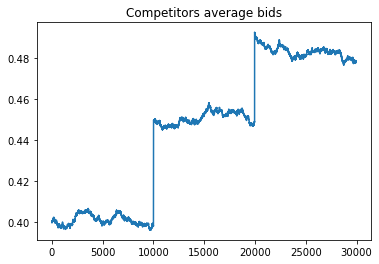

In [7]:
# History of the average bid parameter of the competitors
plt.figure()
plt.plot(np.linspace(0, n_users, n_users+1),mu_parameters)
plt.title('Competitors average bids')
#plt.savefig('IncreasingAverageBid.png')
plt.show()

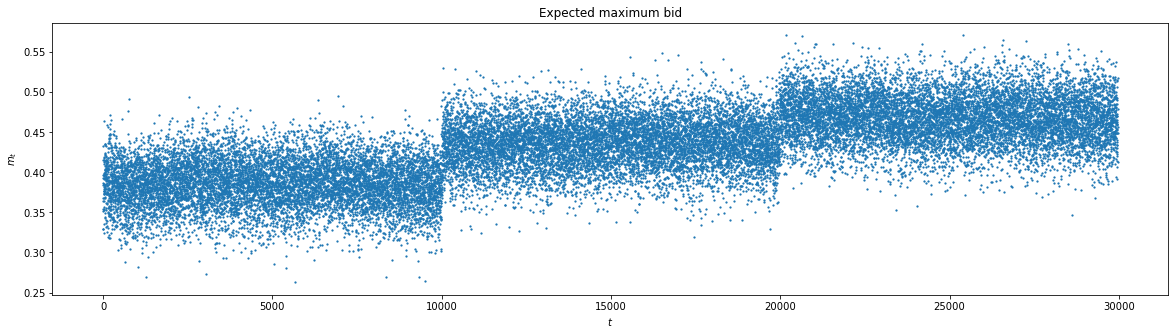

In [8]:
# Expected maximum bid
plt.figure(figsize=(20, 5))
plt.scatter(np.linspace(0, n_users, n_users+1), m_t, s = 1.5)
#plt.axhline(expected_clairvoyant_bids[0], color = 'red', label = 'Clairvoyant')
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
#plt.savefig('ExpectedMaximumBid_Increasing.png')
plt.show()

## Low budget

In [9]:
## PARAMETERS
# publisher's fixed parameters
n_slots = 3
lmbd = np.array([1, 1, 1]) # case in which all the slots are equivalent

# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.ones(4)
v = np.array([0.7, 1.1, 1.4, 0.85])

my_valuation = 0.6

B = n_users/10 
rho = B/n_users


m_t = np.sort(other_bids, axis=0)[-n_slots] # To win it's sufficient that our bid is grater or equal than the n_slot-th biggest bid

available_bids = np.linspace(0,my_valuation,100)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

#
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

### One trial only

In [10]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = np.linspace(0, my_valuation, 100), 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(0 in winners) # change, here we have more than one winner, so it's sufficient that I (index 0) am between them
    f_t, c_t = (my_valuation-my_bid)*my_win, my_bid*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total number of Wins: {total_wins}')
print(f'Total number of auctions: {n_users}')
print(f'Total number of competitors: {n_adv}')

Total number of Wins: 3288
Total number of auctions: 29965
Total number of competitors: 4


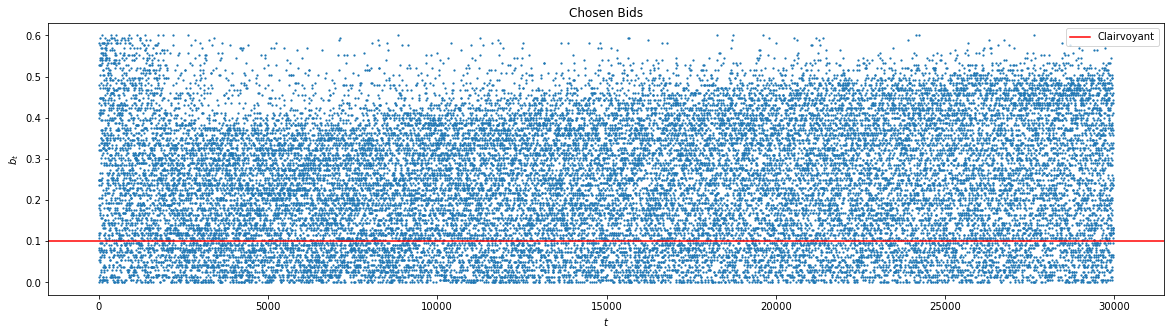

In [11]:
plt.figure(figsize=(20, 5))
time = np.linspace(0, len(my_bids),len(my_bids))
plt.scatter(time, my_bids,s=1.5)
plt.axhline(expected_clairvoyant_bids[0], color = 'red', label = 'Clairvoyant')
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.legend()
#plt.savefig('ChosenBids_LowBudget.png')
plt.show()

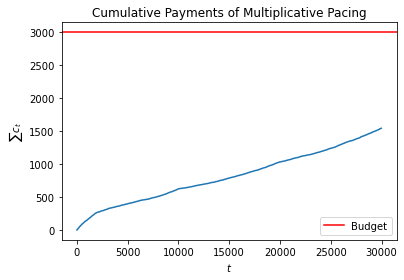

In [12]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

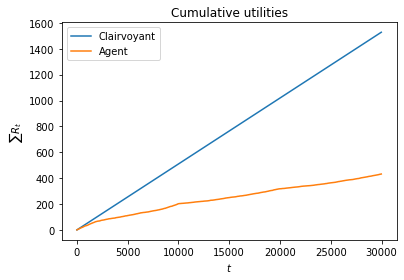

In [13]:
cumulative_clairvoyant_utilities = np.cumsum(expected_clairvoyant_utilities)
cumulative_agent_utilities = np.cumsum(utilities)
plt.plot(cumulative_clairvoyant_utilities, label='Clairvoyant')
plt.plot(cumulative_agent_utilities, label='Agent')
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative utilities')
plt.legend()
plt.show()

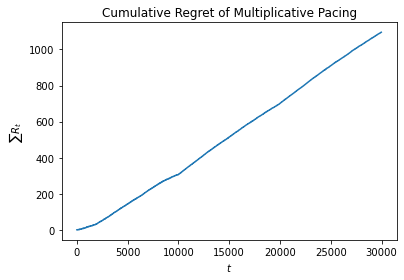

In [14]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

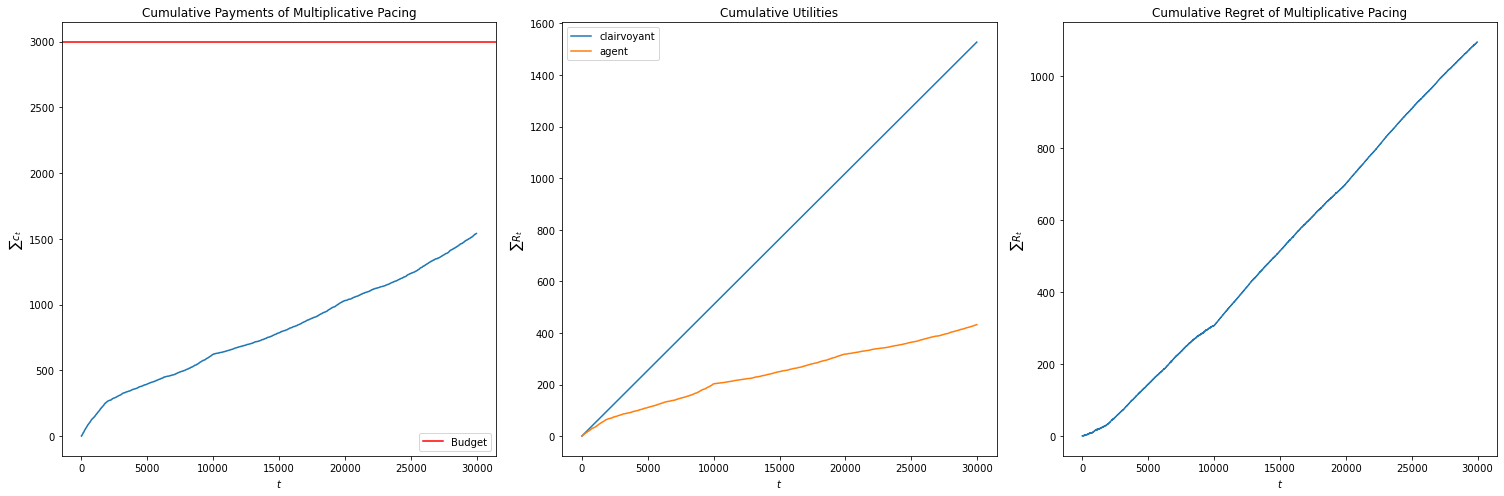

In [15]:
# All in a unique plot
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# First plot - Cumulative Payments of Multiplicative Pacing
cumulative_payments = np.cumsum(my_payments)
axs[0].plot(cumulative_payments)
axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$\sum c_t$')
axs[0].axhline(B, color='red', label='Budget')
axs[0].legend()
axs[0].set_title('Cumulative Payments of Multiplicative Pacing')

# Second plot - Cumulative Utilities
cumulative_clairvoyant_utilities = np.cumsum(expected_clairvoyant_utilities)
cumulative_agent_utilities = np.cumsum(utilities)
axs[1].plot(cumulative_clairvoyant_utilities, label='clairvoyant')
axs[1].plot(cumulative_agent_utilities, label='agent')
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\sum R_t$')
axs[1].set_title('Cumulative Utilities')
axs[1].legend()

# Third plot - Cumulative Regret of Multiplicative Pacing
cumulative_regret = np.cumsum(expected_clairvoyant_utilities - utilities)
axs[2].plot(cumulative_regret)
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$\sum R_t$')
axs[2].set_title('Cumulative Regret of Multiplicative Pacing')


plt.tight_layout()
plt.show()

### More trials

In [16]:
n_epochs = 50
all_regrets = []
all_payments = []
all_utilities = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = np.linspace(0, my_valuation, 100), 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(0 in winners)
        f_t, c_t = (my_valuation-my_bid)*my_win, my_bid*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_utilities.append(np.cumsum(utilities))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_utilities = np.array(all_utilities).mean(axis=0)
std_utilities = np.array(all_utilities).std(axis=0)

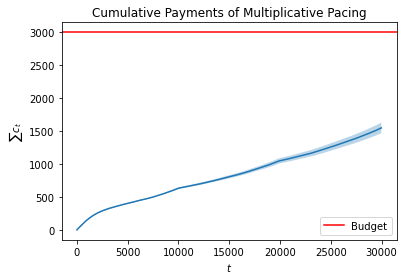

In [17]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

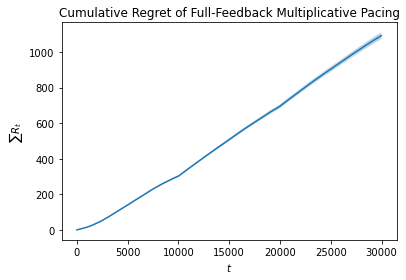

In [18]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

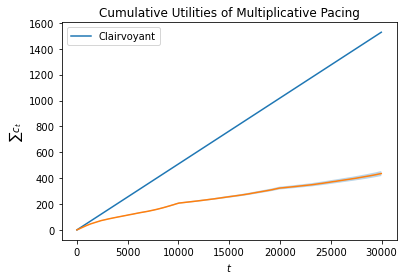

In [19]:
plt.plot(cumulative_clairvoyant_utilities, label='Clairvoyant')
plt.plot(np.arange(n_users), avg_utilities)
plt.fill_between(np.arange(n_users), avg_utilities-std_utilities, avg_utilities+std_utilities, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.legend()
plt.title('Cumulative Utilities of Multiplicative Pacing')
plt.show()

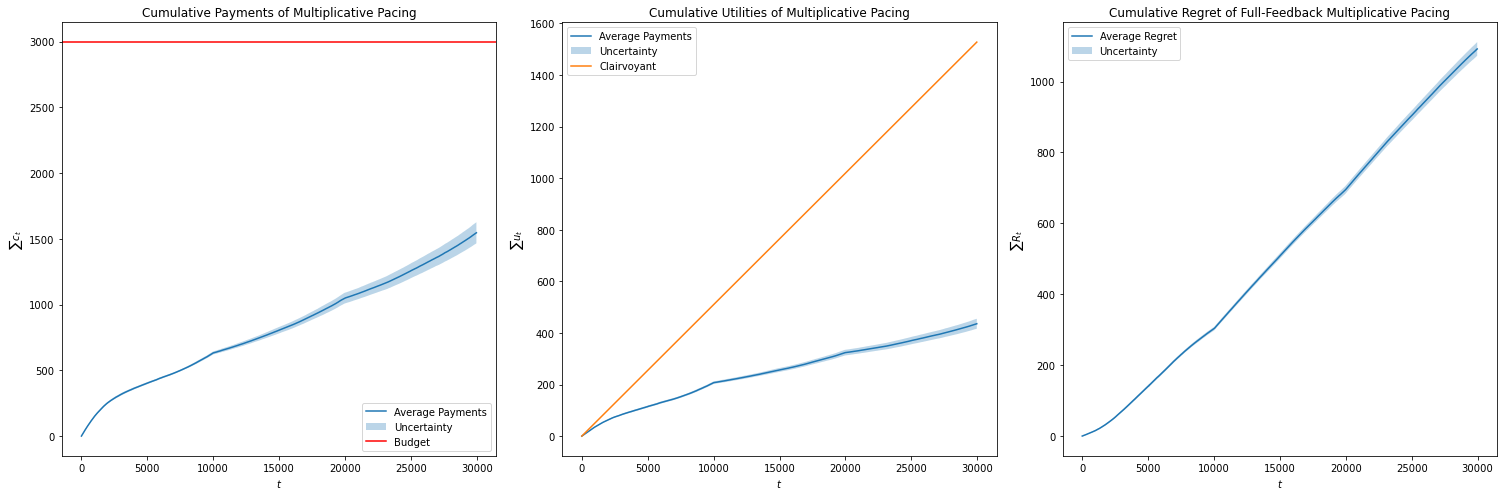

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Plot 1: Cumulative Payments
axs[0].plot(np.arange(n_users), avg_payments, label = 'Average Payments')
axs[0].fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3, label = 'Uncertainty')
axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$\sum c_t$')
axs[0].axhline(B, color='red', label='Budget')
axs[0].legend()
axs[0].set_title('Cumulative Payments of Multiplicative Pacing')

# Plot 2: Cumulative Utilities
axs[1].plot(np.arange(n_users), avg_utilities, label = 'Average Payments')
axs[1].fill_between(np.arange(n_users), avg_utilities-std_utilities, avg_utilities+std_utilities, alpha=0.3, label = 'Uncertainty')
axs[1].plot(cumulative_clairvoyant_utilities, label='Clairvoyant')
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\sum u_t$')
axs[1].legend()
axs[1].set_title('Cumulative Utilities of Multiplicative Pacing')

# Plot 3: Cumulative Regret
axs[2].plot(np.arange(n_users), avg_regret, label = 'Average Regret')
axs[2].fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3, label = 'Uncertainty')
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$\sum R_t$')
axs[2].legend()
axs[2].set_title('Cumulative Regret of Full-Feedback Multiplicative Pacing')


plt.tight_layout()
#plt.savefig('LowBudget_Analysis.png')
plt.show()

## Fair budget

In [21]:
## PARAMETERS
# publisher's fixed parameters
n_slots = 3
lmbd = np.array([1, 1, 1]) # case in which all the slots are equivalent

# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.ones(4)
v = np.array([0.7, 1.1, 1.4, 0.85])

my_valuation = 0.6

B = n_users/2 
rho = B/n_users


m_t = np.sort(other_bids, axis=0)[-n_slots] # To win it's sufficient that our bid is grater or equal than the n_slot-th biggest bid

available_bids = np.linspace(0, my_valuation, 100)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

#
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

### One trial only

In [22]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = np.linspace(0, my_valuation, 100), 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(0 in winners) # change, here we have more than one winner, so it's sufficient that I (index 0) am between them
    f_t, c_t = (my_valuation-my_bid)*my_win, my_bid*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total number of Wins: {total_wins}')
print(f'Total number of auctions: {n_users}')
print(f'Total number of competitors: {n_adv}')

Total number of Wins: 17151
Total number of auctions: 29965
Total number of competitors: 4


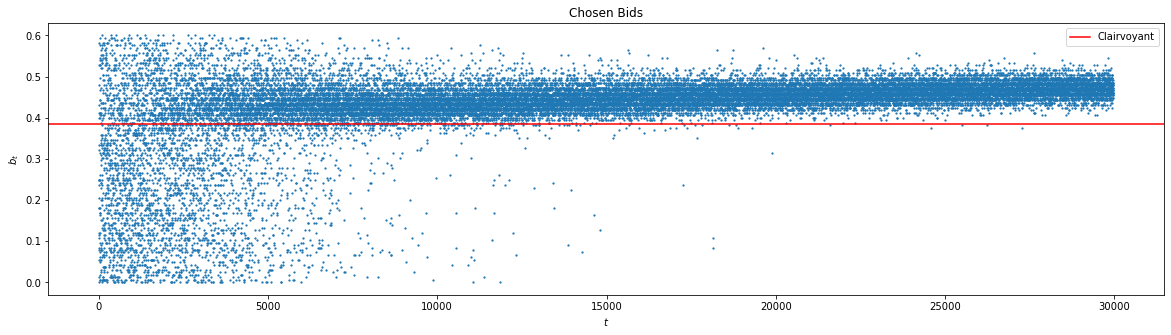

In [23]:
plt.figure(figsize=(20, 5))
time = np.linspace(0, len(my_bids),len(my_bids))
plt.scatter(time, my_bids,s=1.5)
plt.axhline(expected_clairvoyant_bids[0], color = 'red', label = 'Clairvoyant')
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.legend()
#plt.savefig('ChosenBids_FairBudget.png')
plt.show()

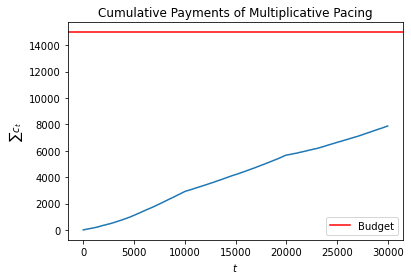

In [24]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

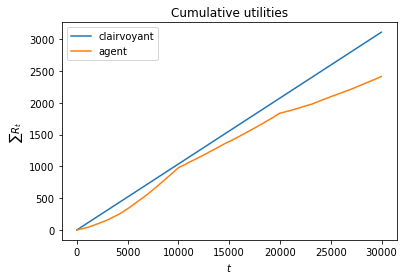

In [25]:
cumulative_clairvoyant_utilities = np.cumsum(expected_clairvoyant_utilities)
cumulative_agent_utilities = np.cumsum(utilities)
plt.plot(cumulative_clairvoyant_utilities, label='clairvoyant')
plt.plot(cumulative_agent_utilities, label='agent')
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative utilities')
plt.legend()
plt.show()

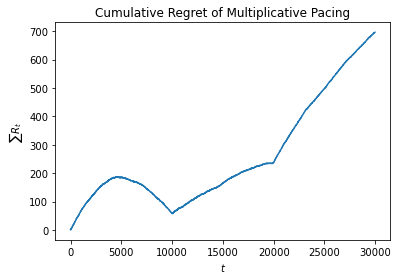

In [26]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

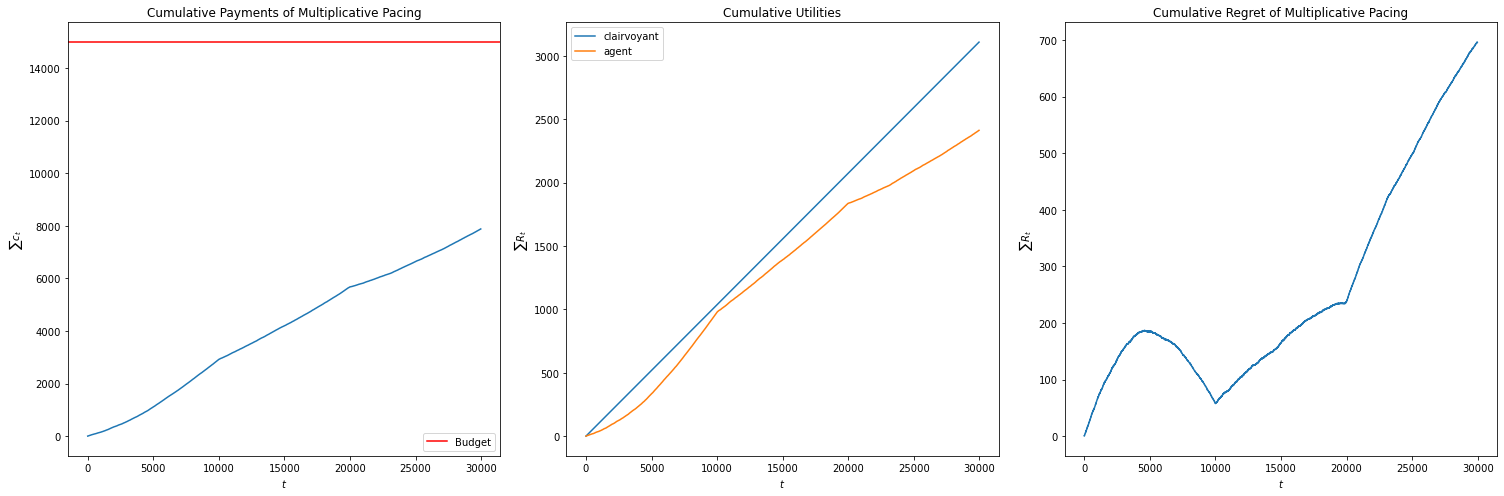

In [27]:
# All in a unique plot
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# First plot - Cumulative Payments of Multiplicative Pacing
cumulative_payments = np.cumsum(my_payments)
axs[0].plot(cumulative_payments)
axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$\sum c_t$')
axs[0].axhline(B, color='red', label='Budget')
axs[0].legend()
axs[0].set_title('Cumulative Payments of Multiplicative Pacing')

# Second plot - Cumulative Utilities
cumulative_clairvoyant_utilities = np.cumsum(expected_clairvoyant_utilities)
cumulative_agent_utilities = np.cumsum(utilities)
axs[1].plot(cumulative_clairvoyant_utilities, label='clairvoyant')
axs[1].plot(cumulative_agent_utilities, label='agent')
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\sum R_t$')
axs[1].set_title('Cumulative Utilities')
axs[1].legend()

# Third plot - Cumulative Regret of Multiplicative Pacing
cumulative_regret = np.cumsum(expected_clairvoyant_utilities - utilities)
axs[2].plot(cumulative_regret)
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$\sum R_t$')
axs[2].set_title('Cumulative Regret of Multiplicative Pacing')


plt.tight_layout()
plt.show()

### More trials

In [28]:
n_epochs = 50
all_regrets = []
all_payments = []
all_utilities = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = np.linspace(0, my_valuation, 100), 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(0 in winners)
        f_t, c_t = (my_valuation-my_bid)*my_win, my_bid*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_utilities.append(np.cumsum(utilities))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_utilities = np.array(all_utilities).mean(axis=0)
std_utilities = np.array(all_utilities).std(axis=0)

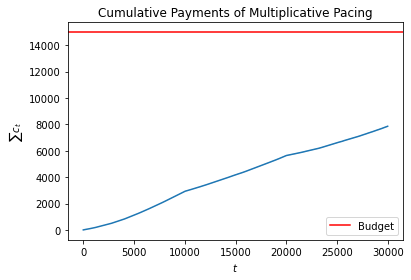

In [29]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

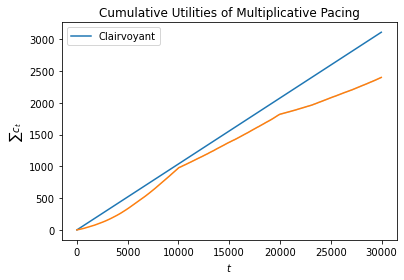

In [30]:
plt.plot(cumulative_clairvoyant_utilities, label='Clairvoyant')
plt.plot(np.arange(n_users), avg_utilities)
plt.fill_between(np.arange(n_users), avg_utilities-std_utilities, avg_utilities+std_utilities, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.legend()
plt.title('Cumulative Utilities of Multiplicative Pacing')
plt.show()

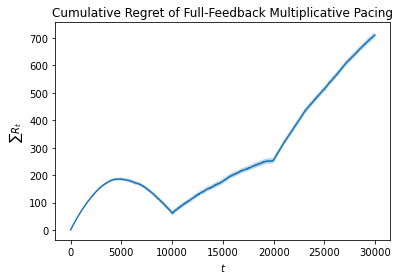

In [31]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

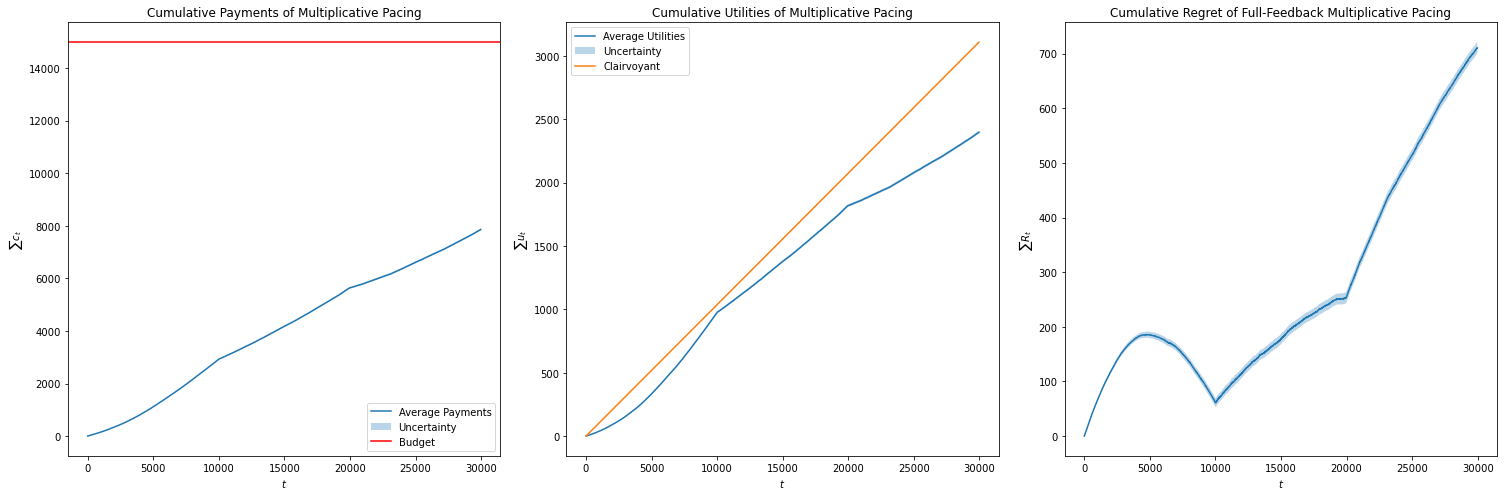

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Plot 1: Cumulative Payments
axs[0].plot(np.arange(n_users), avg_payments, label = 'Average Payments')
axs[0].fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3, label = 'Uncertainty')
axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$\sum c_t$')
axs[0].axhline(B, color='red', label='Budget')
axs[0].legend()
axs[0].set_title('Cumulative Payments of Multiplicative Pacing')

# Plot 2: Cumulative Utilities
axs[1].plot(np.arange(n_users), avg_utilities, label = 'Average Utilities')
axs[1].fill_between(np.arange(n_users), avg_utilities-std_utilities, avg_utilities+std_utilities, alpha=0.3, label = 'Uncertainty')
axs[1].plot(cumulative_clairvoyant_utilities, label='Clairvoyant')
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\sum u_t$')
axs[1].legend()
axs[1].set_title('Cumulative Utilities of Multiplicative Pacing')

# Plot 3: Cumulative Regret
axs[2].plot(np.arange(n_users), avg_regret, label = 'Average Regret')
axs[2].fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3, label = 'Uncertainty')
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$\sum R_t$')
axs[2].set_title('Cumulative Regret of Full-Feedback Multiplicative Pacing')

plt.tight_layout()
plt.savefig('FairBudget_Analysis.png')
plt.show()

# Decreasing jumps

In [33]:
## LOAD DATA
file_path = "Dati_1/DecreasingJumps.npz"

data = np.load(file_path)
other_bids = data['other_bids']
n_users = data['n_users']
mu_parameters = data['mu_parameters']

n_slots = 3 # Needed for the plot
m_t = np.sort(other_bids, axis=0)[-n_slots] # Needed for the plot

print(f"Matrices loaded from {file_path}")

Matrices loaded from Dati_1/DecreasingJumps.npz


## Environment situation

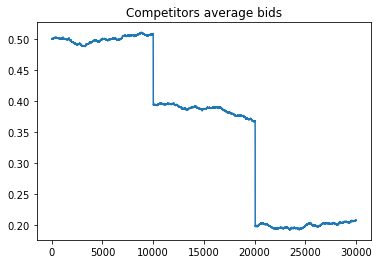

In [34]:
# History of the average bid parameter of the competitors
plt.figure()
plt.plot(np.linspace(0, n_users, n_users+1),mu_parameters)
plt.title('Competitors average bids')
#plt.savefig('DecreasingAverageBid.png')
plt.show()

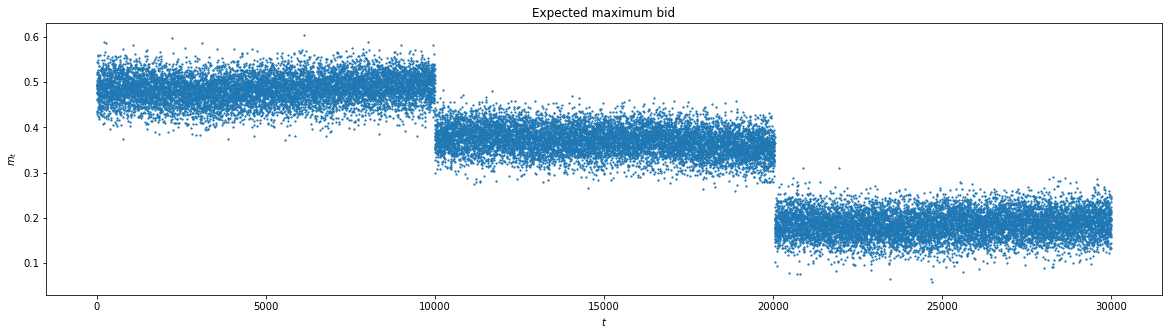

In [35]:
# Expected maximum bid
plt.figure(figsize=(20, 5))
plt.scatter(np.linspace(0, n_users, n_users+1), m_t, s = 1.5)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

## Low budget

In [36]:
## PARAMETERS
# publisher's fixed parameters
n_slots = 3
lmbd = np.array([1, 1, 1]) # case in which all the slots are equivalent

# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.ones(4)
v = np.array([0.7, 1.1, 1.4, 0.85])

my_valuation = 0.6

B = n_users/10 
rho = B/n_users


m_t = np.sort(other_bids, axis=0)[-n_slots] # To win it's sufficient that our bid is grater or equal than the n_slot-th biggest bid

available_bids = np.linspace(0, my_valuation, 100)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

#
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

### One trial only

In [37]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(0 in winners) # change, here we have more than one winner, so it's sufficient that I (index 0) am between them
    f_t, c_t = (my_valuation-my_bid)*my_win, my_bid*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total number of Wins: {total_wins}')
print(f'Total number of auctions: {n_users}')
print(f'Total number of competitors: {n_adv}')

Total number of Wins: 7840
Total number of auctions: 30014
Total number of competitors: 4


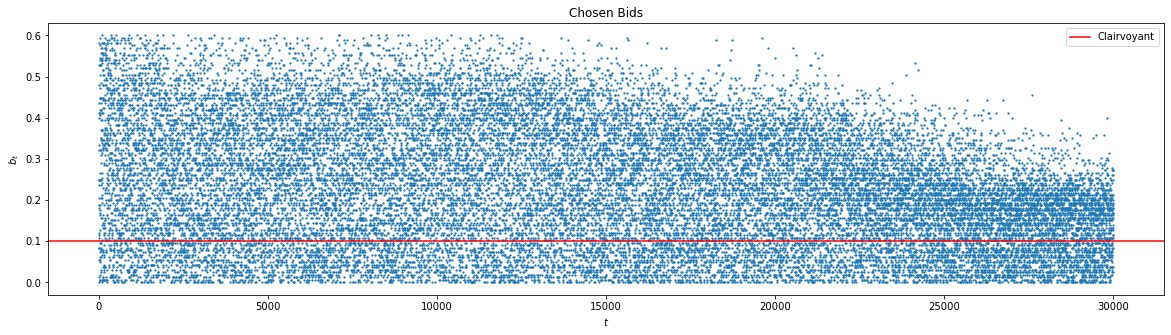

In [38]:
plt.figure(figsize=(20, 5))
time = np.linspace(0, len(my_bids),len(my_bids))
plt.scatter(time, my_bids,s=1.5)
plt.axhline(expected_clairvoyant_bids[0], color = 'red', label = 'Clairvoyant')
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.legend()
plt.show()

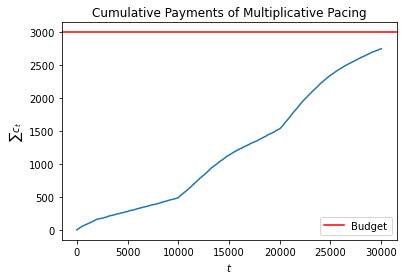

In [39]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

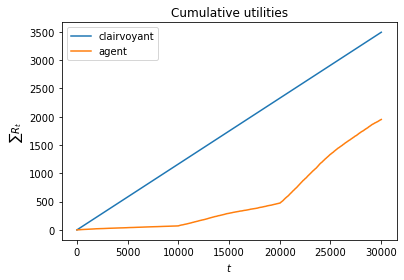

In [40]:
cumulative_clairvoyant_utilities = np.cumsum(expected_clairvoyant_utilities)
cumulative_agent_utilities = np.cumsum(utilities)
plt.plot(cumulative_clairvoyant_utilities, label='clairvoyant')
plt.plot(cumulative_agent_utilities, label='agent')
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative utilities')
plt.legend()
plt.show()

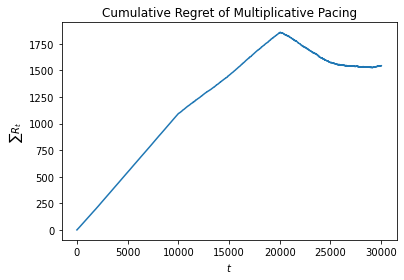

In [41]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

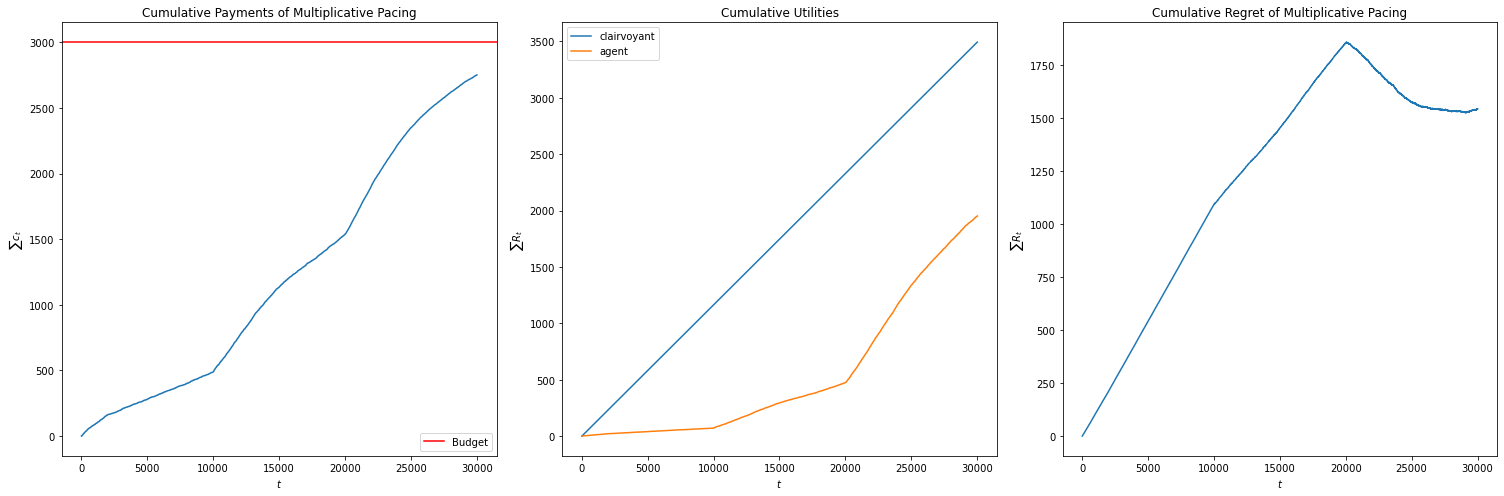

In [42]:
# All in a unique plot
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# First plot - Cumulative Payments of Multiplicative Pacing
cumulative_payments = np.cumsum(my_payments)
axs[0].plot(cumulative_payments)
axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$\sum c_t$')
axs[0].axhline(B, color='red', label='Budget')
axs[0].legend()
axs[0].set_title('Cumulative Payments of Multiplicative Pacing')

# Second plot - Cumulative Utilities
cumulative_clairvoyant_utilities = np.cumsum(expected_clairvoyant_utilities)
cumulative_agent_utilities = np.cumsum(utilities)
axs[1].plot(cumulative_clairvoyant_utilities, label='clairvoyant')
axs[1].plot(cumulative_agent_utilities, label='agent')
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\sum R_t$')
axs[1].set_title('Cumulative Utilities')
axs[1].legend()

# Third plot - Cumulative Regret of Multiplicative Pacing
cumulative_regret = np.cumsum(expected_clairvoyant_utilities - utilities)
axs[2].plot(cumulative_regret)
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$\sum R_t$')
axs[2].set_title('Cumulative Regret of Multiplicative Pacing')


plt.tight_layout()
plt.show()

### More trials

In [43]:
n_epochs = 50
all_regrets = []
all_payments = []
all_utilities = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(0 in winners)
        f_t, c_t = (my_valuation-my_bid)*my_win, my_bid*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_utilities.append(np.cumsum(utilities))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_utilities = np.array(all_utilities).mean(axis=0)
std_utilities = np.array(all_utilities).std(axis=0)

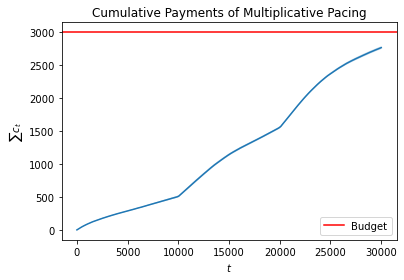

In [44]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

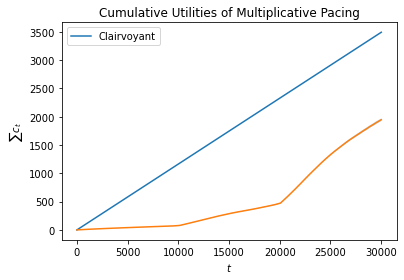

In [45]:
plt.plot(cumulative_clairvoyant_utilities, label='Clairvoyant')
plt.plot(np.arange(n_users), avg_utilities)
plt.fill_between(np.arange(n_users), avg_utilities-std_utilities, avg_utilities+std_utilities, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.legend()
plt.title('Cumulative Utilities of Multiplicative Pacing')
plt.show()

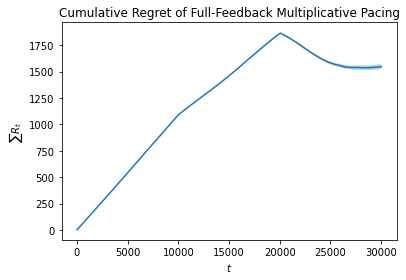

In [46]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

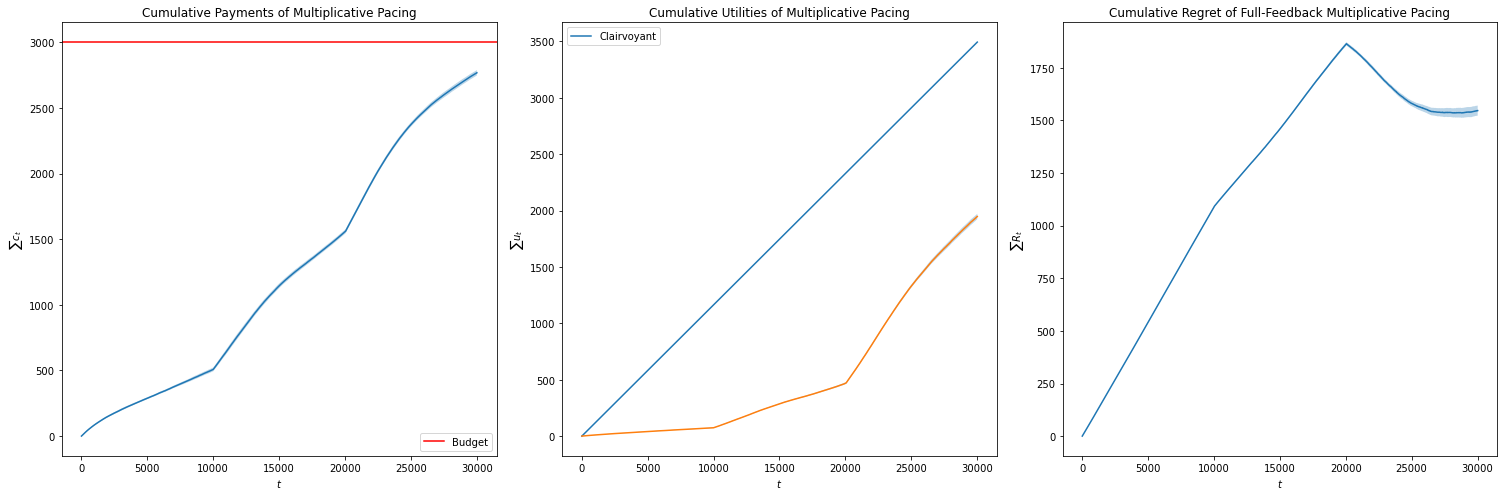

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Plot 1: Cumulative Payments
axs[0].plot(np.arange(n_users), avg_payments)
axs[0].fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$\sum c_t$')
axs[0].axhline(B, color='red', label='Budget')
axs[0].legend()
axs[0].set_title('Cumulative Payments of Multiplicative Pacing')

# Plot 2: Cumulative Utilities
axs[1].plot(cumulative_clairvoyant_utilities, label='Clairvoyant')
axs[1].plot(np.arange(n_users), avg_utilities)
axs[1].fill_between(np.arange(n_users), avg_utilities-std_utilities, avg_utilities+std_utilities, alpha=0.3)
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\sum u_t$')
axs[1].legend()
axs[1].set_title('Cumulative Utilities of Multiplicative Pacing')

# Plot 3: Cumulative Regret
axs[2].plot(np.arange(n_users), avg_regret)
axs[2].fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$\sum R_t$')
axs[2].set_title('Cumulative Regret of Full-Feedback Multiplicative Pacing')

plt.tight_layout()
plt.show()

## Fair budget

In [48]:
## PARAMETERS
# publisher's fixed parameters
n_slots = 3
lmbd = np.array([1, 1, 1]) # case in which all the slots are equivalent

# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.ones(4)
v = np.array([0.7, 1.1, 1.4, 0.85])

my_valuation = 0.6

B = n_users/2 
rho = B/n_users


m_t = np.sort(other_bids, axis=0)[-n_slots] # To win it's sufficient that our bid is grater or equal than the n_slot-th biggest bid

available_bids = np.linspace(0, my_valuation, 100)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

#
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

### One trial only

In [49]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(0 in winners) # change, here we have more than one winner, so it's sufficient that I (index 0) am between them
    f_t, c_t = (my_valuation-my_bid)*my_win, my_bid*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total number of Wins: {total_wins}')
print(f'Total number of auctions: {n_users}')
print(f'Total number of competitors: {n_adv}')

Total number of Wins: 21946
Total number of auctions: 30014
Total number of competitors: 4


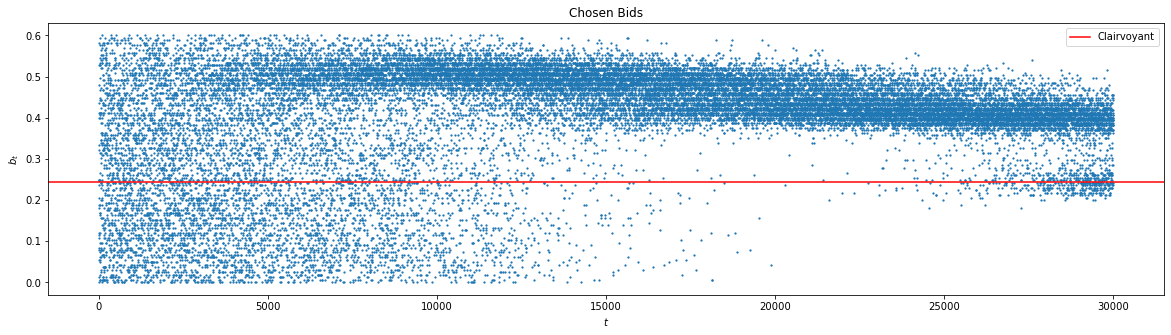

In [50]:
plt.figure(figsize=(20, 5))
time = np.linspace(0, len(my_bids),len(my_bids))
plt.scatter(time, my_bids,s=1.5)
plt.axhline(expected_clairvoyant_bids[0], color = 'red', label = 'Clairvoyant')
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.legend()
plt.show()

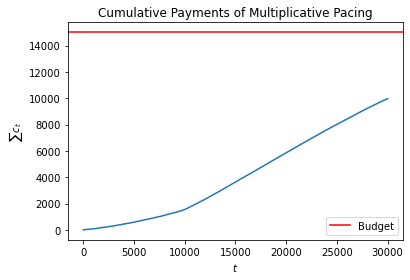

In [51]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

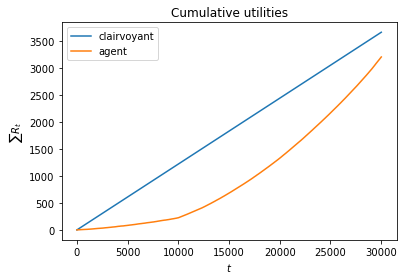

In [52]:
cumulative_clairvoyant_utilities = np.cumsum(expected_clairvoyant_utilities)
cumulative_agent_utilities = np.cumsum(utilities)
plt.plot(cumulative_clairvoyant_utilities, label='clairvoyant')
plt.plot(cumulative_agent_utilities, label='agent')
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative utilities')
plt.legend()
plt.show()

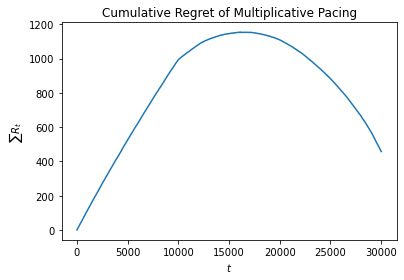

In [53]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

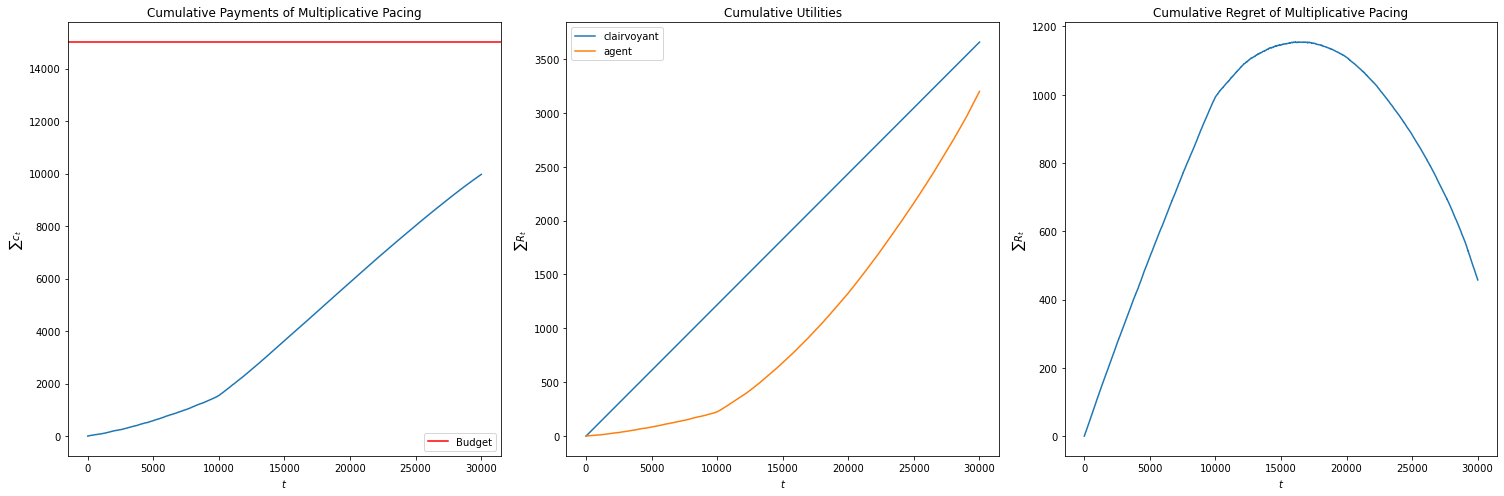

In [54]:
# All in a unique plot
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# First plot - Cumulative Payments of Multiplicative Pacing
cumulative_payments = np.cumsum(my_payments)
axs[0].plot(cumulative_payments)
axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$\sum c_t$')
axs[0].axhline(B, color='red', label='Budget')
axs[0].legend()
axs[0].set_title('Cumulative Payments of Multiplicative Pacing')

# Second plot - Cumulative Utilities
cumulative_clairvoyant_utilities = np.cumsum(expected_clairvoyant_utilities)
cumulative_agent_utilities = np.cumsum(utilities)
axs[1].plot(cumulative_clairvoyant_utilities, label='clairvoyant')
axs[1].plot(cumulative_agent_utilities, label='agent')
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\sum R_t$')
axs[1].set_title('Cumulative Utilities')
axs[1].legend()

# Third plot - Cumulative Regret of Multiplicative Pacing
cumulative_regret = np.cumsum(expected_clairvoyant_utilities - utilities)
axs[2].plot(cumulative_regret)
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$\sum R_t$')
axs[2].set_title('Cumulative Regret of Multiplicative Pacing')


plt.tight_layout()
plt.show()

### More trials

In [55]:
n_epochs = 50
all_regrets = []
all_payments = []
all_utilities = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(0 in winners)
        f_t, c_t = (my_valuation-my_bid)*my_win, my_bid*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_utilities.append(np.cumsum(utilities))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_utilities = np.array(all_utilities).mean(axis=0)
std_utilities = np.array(all_utilities).std(axis=0)

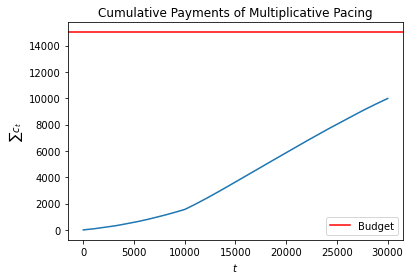

In [56]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

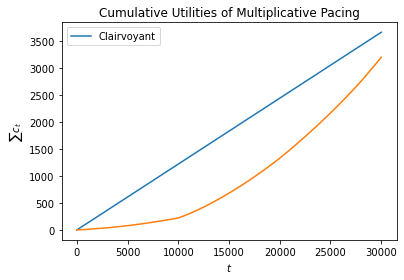

In [57]:
plt.plot(cumulative_clairvoyant_utilities, label='Clairvoyant')
plt.plot(np.arange(n_users), avg_utilities)
plt.fill_between(np.arange(n_users), avg_utilities-std_utilities, avg_utilities+std_utilities, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.legend()
plt.title('Cumulative Utilities of Multiplicative Pacing')
plt.show()

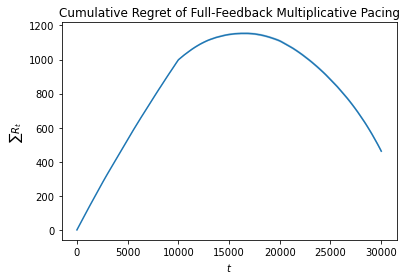

In [58]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

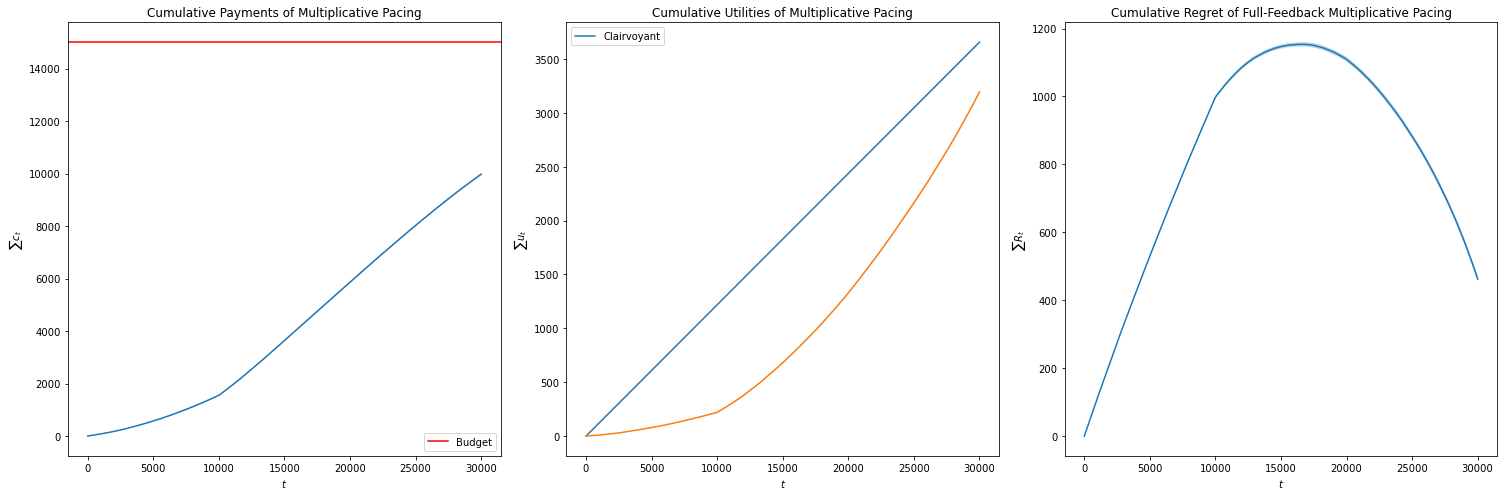

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Plot 1: Cumulative Payments
axs[0].plot(np.arange(n_users), avg_payments)
axs[0].fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$\sum c_t$')
axs[0].axhline(B, color='red', label='Budget')
axs[0].legend()
axs[0].set_title('Cumulative Payments of Multiplicative Pacing')

# Plot 2: Cumulative Utilities
axs[1].plot(cumulative_clairvoyant_utilities, label='Clairvoyant')
axs[1].plot(np.arange(n_users), avg_utilities)
axs[1].fill_between(np.arange(n_users), avg_utilities-std_utilities, avg_utilities+std_utilities, alpha=0.3)
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\sum u_t$')
axs[1].legend()
axs[1].set_title('Cumulative Utilities of Multiplicative Pacing')

# Plot 3: Cumulative Regret
axs[2].plot(np.arange(n_users), avg_regret)
axs[2].fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$\sum R_t$')
axs[2].set_title('Cumulative Regret of Full-Feedback Multiplicative Pacing')

plt.tight_layout()
plt.show()

# Not monotinic jumps

In [60]:
## LOAD DATA
file_path = "Dati_1/NotMonotonicJumps.npz"

data = np.load(file_path)
other_bids = data['other_bids']
n_users = data['n_users']
mu_parameters = data['mu_parameters']

n_slots = 3 # Needed for the plot
m_t = np.sort(other_bids, axis=0)[-n_slots] # Needed for the plot

print(f"Matrices loaded from {file_path}")

Matrices loaded from Dati_1/NotMonotonicJumps.npz


## Environment situation

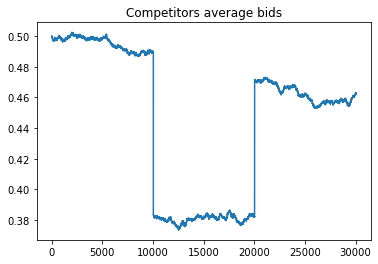

In [61]:
# History of the average bid parameter of the competitors
plt.figure()
plt.plot(np.linspace(0, n_users, n_users+1),mu_parameters)
plt.title('Competitors average bids')
#plt.savefig('NotMonotonicAverageBid.png')
plt.show()

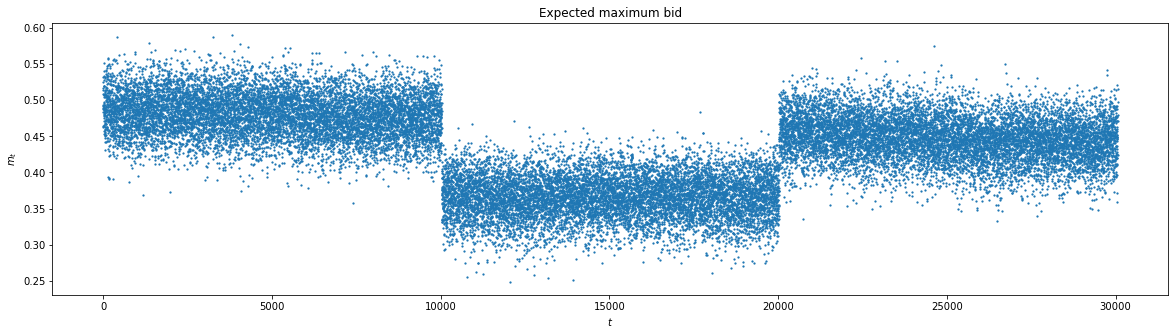

In [62]:
# Expected maximum bid
plt.figure(figsize=(20, 5))
plt.scatter(np.linspace(0, n_users, n_users+1), m_t, s = 1.5)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

## Low budget

In [63]:
## PARAMETERS
# publisher's fixed parameters
n_slots = 3
lmbd = np.array([1, 1, 1]) # case in which all the slots are equivalent

# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.ones(4)
v = np.array([0.7, 1.1, 1.4, 0.85])

my_valuation = 0.6

B = n_users/10 
rho = B/n_users


m_t = np.sort(other_bids, axis=0)[-n_slots] # To win it's sufficient that our bid is grater or equal than the n_slot-th biggest bid

available_bids = np.linspace(0, my_valuation, 100)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

#
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

### One trial only

In [64]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(0 in winners) # change, here we have more than one winner, so it's sufficient that I (index 0) am between them
    f_t, c_t = (my_valuation-my_bid)*my_win, my_bid*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total number of Wins: {total_wins}')
print(f'Total number of auctions: {n_users}')
print(f'Total number of competitors: {n_adv}')

Total number of Wins: 3940
Total number of auctions: 30058
Total number of competitors: 4


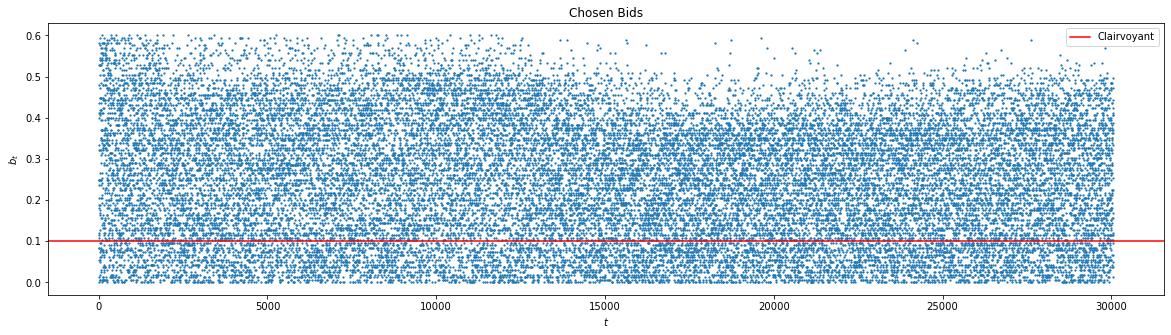

In [65]:
plt.figure(figsize=(20, 5))
time = np.linspace(0, len(my_bids),len(my_bids))
plt.scatter(time, my_bids,s=1.5)
plt.axhline(expected_clairvoyant_bids[0], color = 'red', label = 'Clairvoyant')
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.legend()
plt.show()

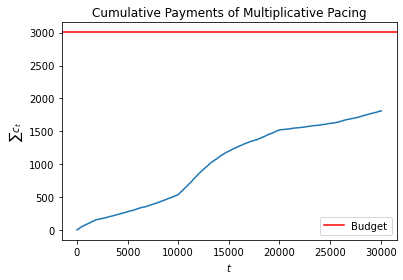

In [66]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

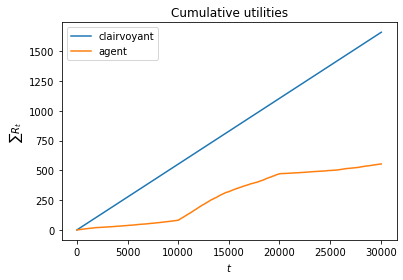

In [67]:
cumulative_clairvoyant_utilities = np.cumsum(expected_clairvoyant_utilities)
cumulative_agent_utilities = np.cumsum(utilities)
plt.plot(cumulative_clairvoyant_utilities, label='clairvoyant')
plt.plot(cumulative_agent_utilities, label='agent')
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative utilities')
plt.legend()
plt.show()

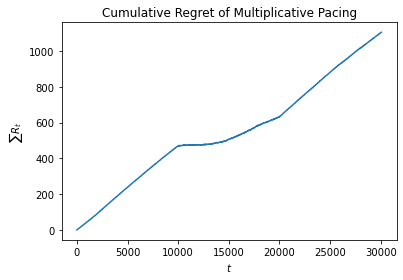

In [68]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

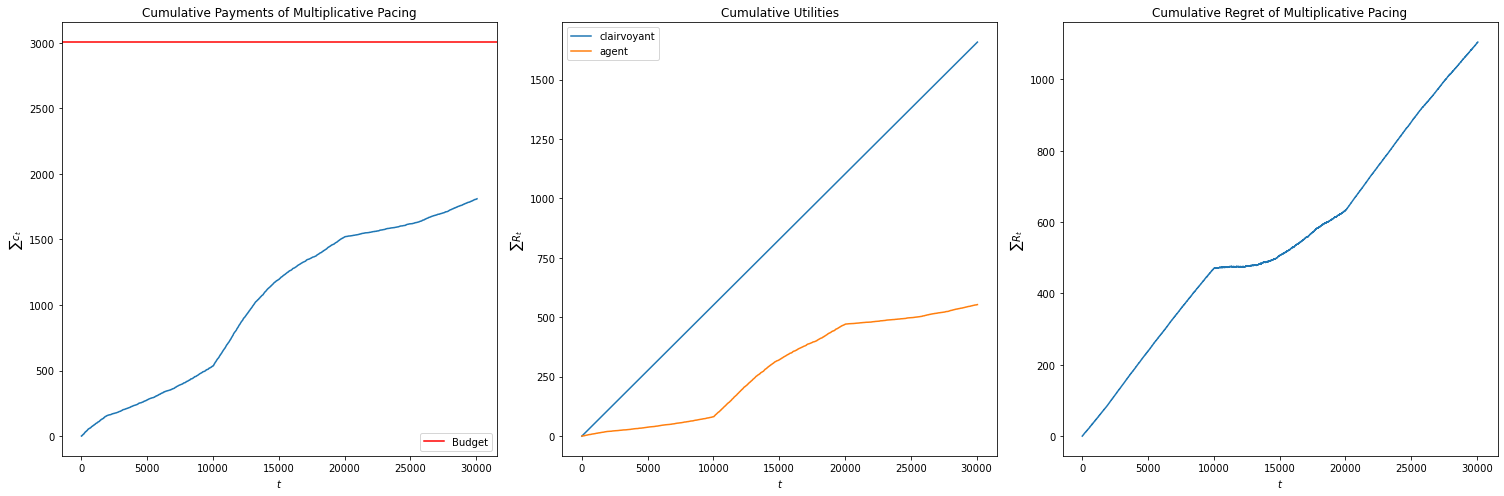

In [69]:
# All in a unique plot
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# First plot - Cumulative Payments of Multiplicative Pacing
cumulative_payments = np.cumsum(my_payments)
axs[0].plot(cumulative_payments)
axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$\sum c_t$')
axs[0].axhline(B, color='red', label='Budget')
axs[0].legend()
axs[0].set_title('Cumulative Payments of Multiplicative Pacing')

# Second plot - Cumulative Utilities
cumulative_clairvoyant_utilities = np.cumsum(expected_clairvoyant_utilities)
cumulative_agent_utilities = np.cumsum(utilities)
axs[1].plot(cumulative_clairvoyant_utilities, label='clairvoyant')
axs[1].plot(cumulative_agent_utilities, label='agent')
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\sum R_t$')
axs[1].set_title('Cumulative Utilities')
axs[1].legend()

# Third plot - Cumulative Regret of Multiplicative Pacing
cumulative_regret = np.cumsum(expected_clairvoyant_utilities - utilities)
axs[2].plot(cumulative_regret)
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$\sum R_t$')
axs[2].set_title('Cumulative Regret of Multiplicative Pacing')


plt.tight_layout()
plt.show()

### More trials

In [70]:
n_epochs = 50
all_regrets = []
all_payments = []
all_utilities = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(0 in winners)
        f_t, c_t = (my_valuation-my_bid)*my_win, my_bid*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_utilities.append(np.cumsum(utilities))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_utilities = np.array(all_utilities).mean(axis=0)
std_utilities = np.array(all_utilities).std(axis=0)

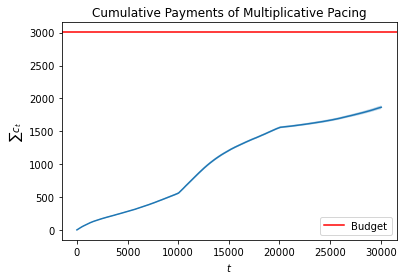

In [71]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

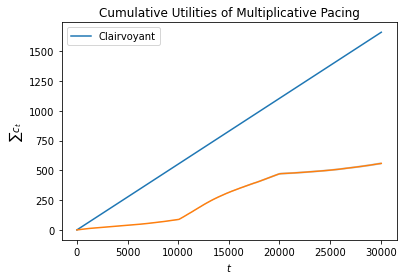

In [72]:
plt.plot(cumulative_clairvoyant_utilities, label='Clairvoyant')
plt.plot(np.arange(n_users), avg_utilities)
plt.fill_between(np.arange(n_users), avg_utilities-std_utilities, avg_utilities+std_utilities, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.legend()
plt.title('Cumulative Utilities of Multiplicative Pacing')
plt.show()

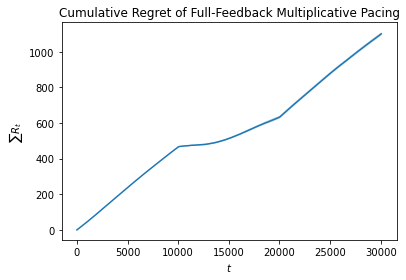

In [73]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

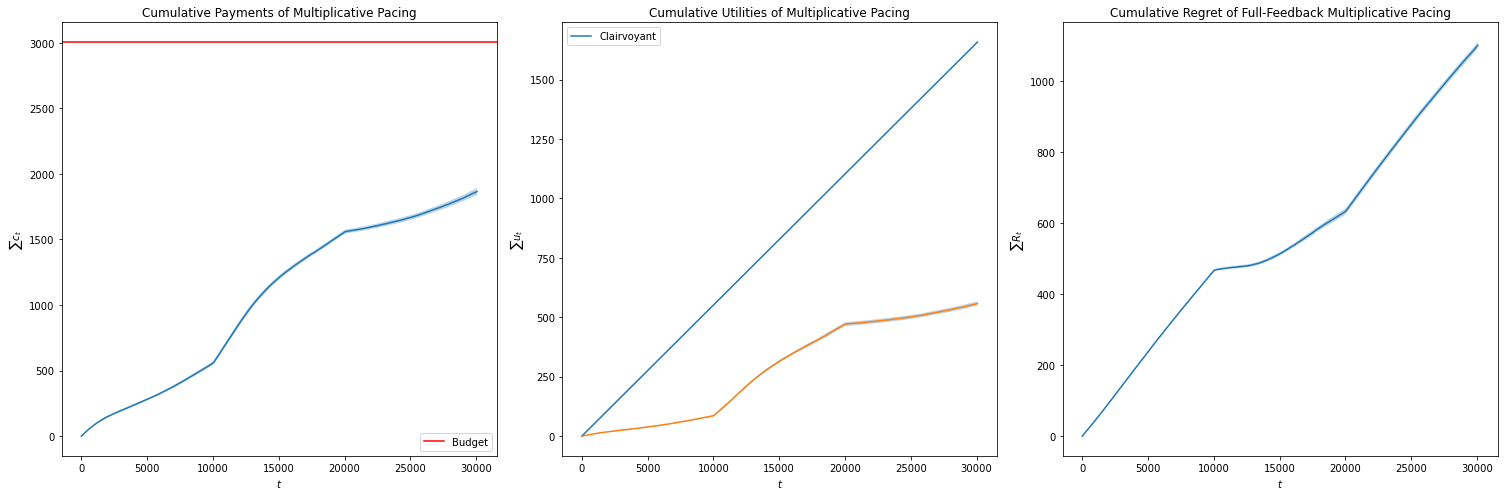

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Plot 1: Cumulative Payments
axs[0].plot(np.arange(n_users), avg_payments)
axs[0].fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$\sum c_t$')
axs[0].axhline(B, color='red', label='Budget')
axs[0].legend()
axs[0].set_title('Cumulative Payments of Multiplicative Pacing')

# Plot 2: Cumulative Utilities
axs[1].plot(cumulative_clairvoyant_utilities, label='Clairvoyant')
axs[1].plot(np.arange(n_users), avg_utilities)
axs[1].fill_between(np.arange(n_users), avg_utilities-std_utilities, avg_utilities+std_utilities, alpha=0.3)
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\sum u_t$')
axs[1].legend()
axs[1].set_title('Cumulative Utilities of Multiplicative Pacing')

# Plot 3: Cumulative Regret
axs[2].plot(np.arange(n_users), avg_regret)
axs[2].fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$\sum R_t$')
axs[2].set_title('Cumulative Regret of Full-Feedback Multiplicative Pacing')

plt.tight_layout()
plt.show()

## Fair budget

In [75]:
## PARAMETERS
# publisher's fixed parameters
n_slots = 3
lmbd = np.array([1, 1, 1]) # case in which all the slots are equivalent

# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.ones(4)
v = np.array([0.7, 1.1, 1.4, 0.85])

my_valuation = 0.6

B = n_users/2 
rho = B/n_users


m_t = np.sort(other_bids, axis=0)[-n_slots] # To win it's sufficient that our bid is grater or equal than the n_slot-th biggest bid

available_bids = np.linspace(0, my_valuation, 100)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

#
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

### One trial only

In [76]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(0 in winners) # change, here we have more than one winner, so it's sufficient that I (index 0) am between them
    f_t, c_t = (my_valuation-my_bid)*my_win, my_bid*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total number of Wins: {total_wins}')
print(f'Total number of auctions: {n_users}')
print(f'Total number of competitors: {n_adv}')

Total number of Wins: 19067
Total number of auctions: 30058
Total number of competitors: 4


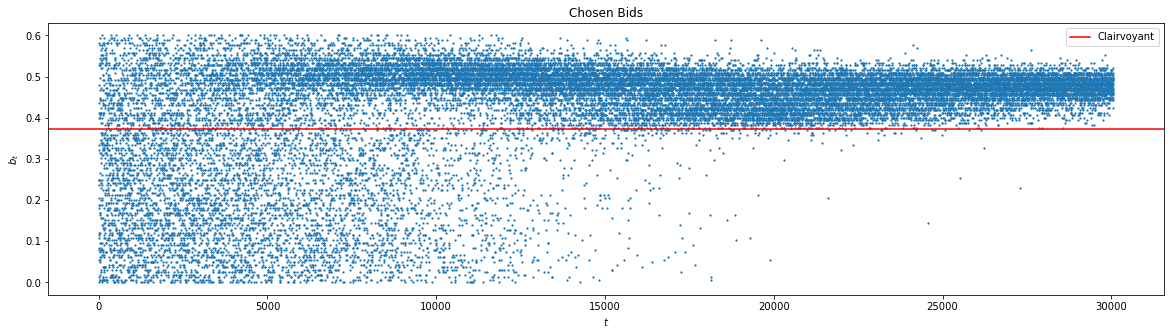

In [77]:
plt.figure(figsize=(20, 5))
time = np.linspace(0, len(my_bids),len(my_bids))
plt.scatter(time, my_bids,s=1.5)
plt.axhline(expected_clairvoyant_bids[0], color = 'red', label = 'Clairvoyant')
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.legend()
plt.show()

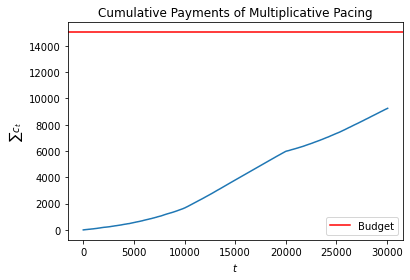

In [78]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

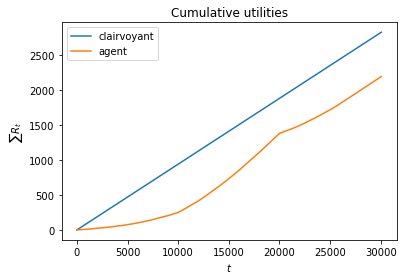

In [79]:
cumulative_clairvoyant_utilities = np.cumsum(expected_clairvoyant_utilities)
cumulative_agent_utilities = np.cumsum(utilities)
plt.plot(cumulative_clairvoyant_utilities, label='clairvoyant')
plt.plot(cumulative_agent_utilities, label='agent')
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative utilities')
plt.legend()
plt.show()

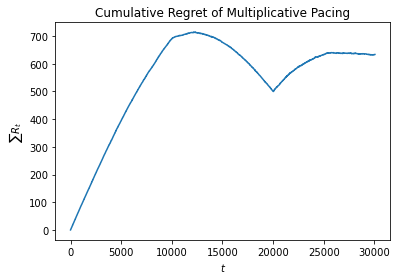

In [80]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

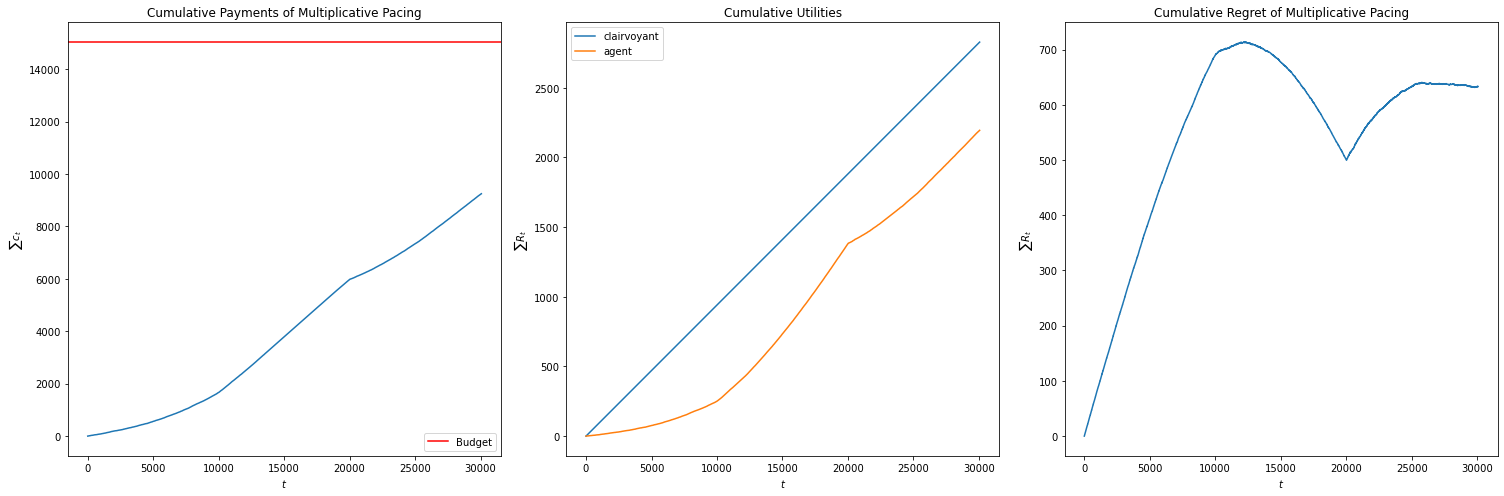

In [81]:
# All in a unique plot
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# First plot - Cumulative Payments of Multiplicative Pacing
cumulative_payments = np.cumsum(my_payments)
axs[0].plot(cumulative_payments)
axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$\sum c_t$')
axs[0].axhline(B, color='red', label='Budget')
axs[0].legend()
axs[0].set_title('Cumulative Payments of Multiplicative Pacing')

# Second plot - Cumulative Utilities
cumulative_clairvoyant_utilities = np.cumsum(expected_clairvoyant_utilities)
cumulative_agent_utilities = np.cumsum(utilities)
axs[1].plot(cumulative_clairvoyant_utilities, label='clairvoyant')
axs[1].plot(cumulative_agent_utilities, label='agent')
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\sum R_t$')
axs[1].set_title('Cumulative Utilities')
axs[1].legend()

# Third plot - Cumulative Regret of Multiplicative Pacing
cumulative_regret = np.cumsum(expected_clairvoyant_utilities - utilities)
axs[2].plot(cumulative_regret)
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$\sum R_t$')
axs[2].set_title('Cumulative Regret of Multiplicative Pacing')


plt.tight_layout()
plt.show()

### More trials

In [82]:
n_epochs = 50
all_regrets = []
all_payments = []
all_utilities = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = GeneralizedFirstPriceAuction(np.ones(n_adv+1), lmbd)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(0 in winners)
        f_t, c_t = (my_valuation-my_bid)*my_win, my_bid*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_utilities.append(np.cumsum(utilities))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_utilities = np.array(all_utilities).mean(axis=0)
std_utilities = np.array(all_utilities).std(axis=0)

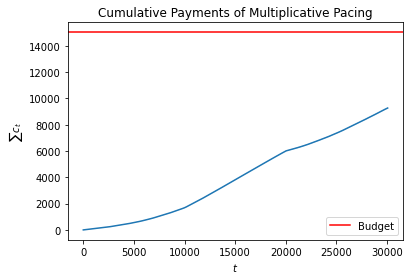

In [83]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

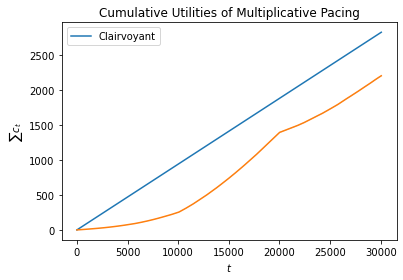

In [84]:
plt.plot(cumulative_clairvoyant_utilities, label='Clairvoyant')
plt.plot(np.arange(n_users), avg_utilities)
plt.fill_between(np.arange(n_users), avg_utilities-std_utilities, avg_utilities+std_utilities, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.legend()
plt.title('Cumulative Utilities of Multiplicative Pacing')
plt.show()

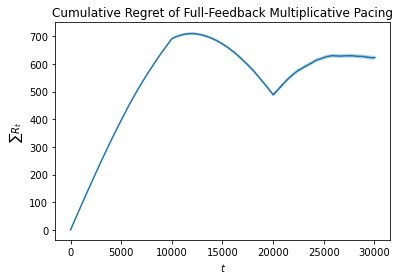

In [85]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

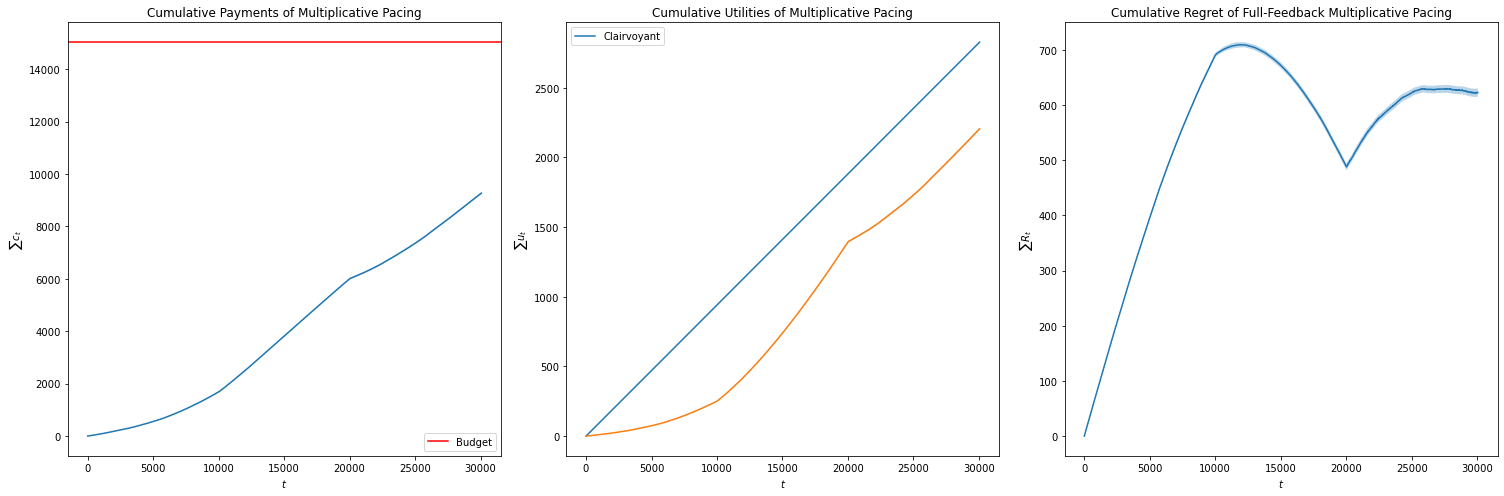

In [86]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Plot 1: Cumulative Payments
axs[0].plot(np.arange(n_users), avg_payments)
axs[0].fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$\sum c_t$')
axs[0].axhline(B, color='red', label='Budget')
axs[0].legend()
axs[0].set_title('Cumulative Payments of Multiplicative Pacing')

# Plot 2: Cumulative Utilities
axs[1].plot(cumulative_clairvoyant_utilities, label='Clairvoyant')
axs[1].plot(np.arange(n_users), avg_utilities)
axs[1].fill_between(np.arange(n_users), avg_utilities-std_utilities, avg_utilities+std_utilities, alpha=0.3)
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\sum u_t$')
axs[1].legend()
axs[1].set_title('Cumulative Utilities of Multiplicative Pacing')

# Plot 3: Cumulative Regret
axs[2].plot(np.arange(n_users), avg_regret)
axs[2].fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$\sum R_t$')
axs[2].set_title('Cumulative Regret of Full-Feedback Multiplicative Pacing')

plt.tight_layout()
plt.show()

# Comments

## Budget

   In each of the three scenarios explored (decreasing, increasing, and non-monotonic jumps), the budget is a crucial parameter in regulating the trade-off between exploration and exploitation. It is important to note that in every case, the agent tends to avoid depleting the budget, even when the budget is low. What changes, however, is the level of aggressiveness in exploration and decisiveness in exploitation.

With a **low budget**, the agent becomes more conservative, since he has not enough exploratory attempts with high bids. This results in the agent getting "lost" in a continuous process of exploration, which might move in the right direction (e.g., decreasing jumps lead to decreasing bids) but with very little exploitation.

When the **budget** is increased to a level **comparable to** that of the **competitors**, the agent seems to achieve the right balance between exploration and exploitation. He's able to privide competitive bidding range that adapts to environmental changes without entirely abandoning the exploration phase.

Finally, with a very **high budget**, exploitation becomes the dominant process at the expense of exploration. This causes the agent to be less responsive to changes in the environment compared to the previous scenario. (Qui magari mostra il grafico delle choosen bids nel caso di decreasing jumps dando high budget, è molto esplicativo)


## Utility and Regret


Let's consider only the most promising case for each environment, specifically the one with a fair budget.  
The clairvoyant will always choose the same bid, derived through linear programming (LP), resulting in linear cumulative utilities.

In all three scenarios, we observe an initial exploration phase (typically for t<5000), where the cumulative utilities are sublinear, leading to linear or even superlinear regret. This happens because during exploration, the agent does not win a high percentage of auctions. After this phase, the agent shifts towards exploitation, which can lead to two outcomes depending on the environment's trend:

- If the expected winning bid is low compared to the agent's valuation, the agent wins a good number of auctions, resulting in superlinear cumulative utilities and a cumulative regret that becomes sublinear or even decreases.

- On the other hand, if the expected winning bid rises, approaching the agent's valuation, the agent tries to win as many auctions as possible but with limited success. This leads to sublinear cumulative utilities and consequently linear or superlinear cumulative regret.

## Winning autions portion

Only one comment to say that in general (always observing the most promising case of fair budget) the FFMultiplicative Pcaing Agent wins much more than 20% of the total number of auctions; notice that there were 5 advertiser totally. 